# Variational autoencoder


Import all the libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.datasets import mnist
from matplotlib import pyplot as plt
import numpy as np
from tensorflow.keras import backend as K

## Data

Load MNIST dataset

In [2]:
def load_mnist():
  # load
  mnist_dataset = mnist.load_data()
  (trainset, testset) = (mnist_dataset[0], mnist_dataset[1])
  (X_train, y_train) = trainset
  (X_test, y_test) = testset
  # preprocess
  X_train = X_train.astype('float32')
  X_train /= 255
  X_test = X_test.astype('float32')
  X_test /= 255
  # Flatten - VAE will be made as fully-connected network
  X_train_fl = X_train.reshape(X_train.shape[0], np.prod(X_train.shape[1:]))
  X_test_fl = X_test.reshape(X_test.shape[0], np.prod(X_test.shape[1:]))
  return X_train_fl, y_train, X_test_fl, y_test

In [3]:
X_train, y_train, X_test, y_test = load_mnist()

Show data

In [4]:
def show_images(X, n_images=4):
  fig = plt.figure()
  for i in range(n_images):
    fig.add_subplot(1, n_images, i+1)
    X_plot = X[i].reshape((28,28))
    plt.imshow(X_plot, cmap='gray')
  plt.show()

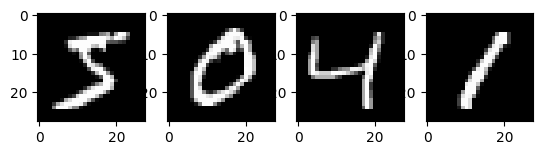

In [5]:
show_images(X_train, n_images=4)

## Model

Network parameters

In [6]:
input_size = 28*28
optimizer = 'adam'
batch_size=128
epochs=50

input_shape = (input_size, )
intermediate_dim = 100
latent_dim = 2

TODO - We will make fully connected VAE. Build encoder of a variational autoencoder. Encoder should consist of input layer, intermediate layer of size 100 and encoding layer of size 2. The last encoding layer should have 2 outputs - mean and variance of Gaussian distribution. We will learn log of variance for easier computation. Use relu activation for the intermediate layer, and no activation for the encoding layer.

In [7]:
inputs = Input(shape=input_shape, name='encoder_input')
intermediate_enc = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(intermediate_enc)
z_log_var = Dense(latent_dim, name='z_log_var')(intermediate_enc)
# Be careful with formulas that follow, variance is a square of standard deviation

TODO - A function for sampling from Gaussian is given. You should add a reparametrization trick. Sampling is embedded into the network using custom Lambda layer.



In [9]:
# function for sampling from the learned distribution

def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    # Sample epsilon = N(0,I)
    epsilon = tf.random.normal(shape=(batch, dim))
    # Put epsilon to the learned distribution
    # z = z_mean + sqrt(var) * epsilon
    # TODO - reformulate the equation for log var
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Lambda layer - use user-defined function as a Keras layer
from keras.layers import Lambda
z = Lambda(sampling, name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')

TODO - Build decoder model. You should have input layer which will later take sampled z as an input. The remaining layers are analogous to the encoder. Use relu activation for intermediate layer, and sigmoid for the output layer.

In [11]:
# build decoder model
# 
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
intermediate_dec = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(input_size, activation='sigmoid')(intermediate_dec)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
# connect encoder and decoder
...
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

TODO - Make custom loss - MSE + KL. Be careful with formulas again, z_log_var is logarithm of variance, and variance is a square of standard deviation.

In [13]:
from keras.losses import mse

reconstruction_loss = mse(inputs, outputs) * input_size  # Multiply by input size for total reconstruction loss
kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
vae_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer=optimizer)


TODO - Train VAE with shuffling and validation split of 0.2

In [14]:
history = vae.fit(X_train, shuffle=True, epochs=epochs, batch_size=batch_size, validation_split=0.2)


Epoch 1/50
375/375 [==============================] - 3s 6ms/step - loss: 62.8213 - val_loss: 48.9513
Epoch 2/50
375/375 [==============================] - 2s 5ms/step - loss: 46.8071 - val_loss: 44.7958
Epoch 3/50
375/375 [==============================] - 2s 5ms/step - loss: 44.4030 - val_loss: 43.7820
Epoch 4/50
375/375 [==============================] - 2s 5ms/step - loss: 43.7060 - val_loss: 43.2965
Epoch 5/50
375/375 [==============================] - 2s 5ms/step - loss: 43.3139 - val_loss: 42.9771
Epoch 6/50
375/375 [==============================] - 2s 5ms/step - loss: 42.9692 - val_loss: 42.6884
Epoch 7/50
375/375 [==============================] - 2s 5ms/step - loss: 42.6959 - val_loss: 42.4310
Epoch 8/50
375/375 [==============================] - 2s 5ms/step - loss: 42.4372 - val_loss: 42.2086
Epoch 9/50
375/375 [==============================] - 2s 5ms/step - loss: 42.2303 - val_loss: 42.0171
Epoch 10/50
375/375 [==============================] - 2s 5ms/step - loss: 42.0194

Plot the training loss

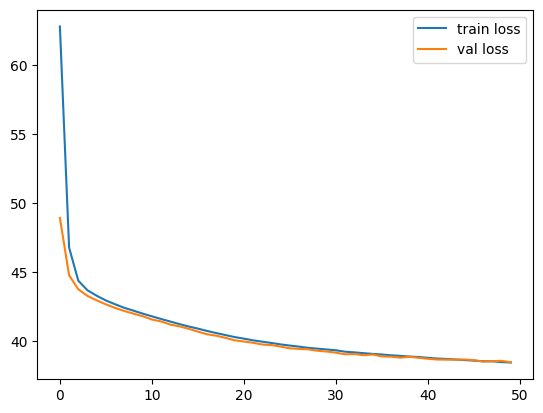

In [15]:
def plot_losses(history):
    losses = history.history
    plt.plot(losses['loss'], label='train loss')
    plt.plot(losses['val_loss'], label='val loss')
    plt.legend()
    plt.show()

plot_losses(history)

## Results

TODO - Reconstruct the test images, plot 10 of them

313/313 [==============================] - 1s 3ms/step


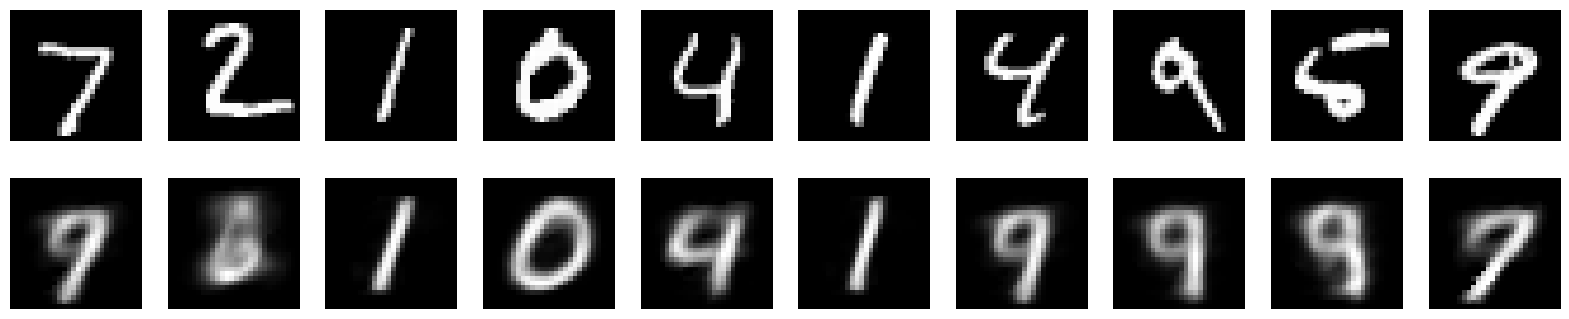

In [16]:
decoded_images = vae.predict(X_test)

def plot_orig_and_rec(orig_images, decoded_images, n_images=10):
    fig, axes = plt.subplots(2, n_images, figsize=(20, 4))
    for i in range(n_images):
        axes[0, i].imshow(orig_images[i].reshape(28, 28), cmap='gray')
        axes[1, i].imshow(decoded_images[i].reshape(28, 28), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].axis('off')
    plt.show()

plot_orig_and_rec(X_test, decoded_images, n_images=10)


TODO - Generate 10 new images by sampling z from N(0,I) with np.random.normal and passing it through the decoder.

1/1 [==============================] - 0s 47ms/step


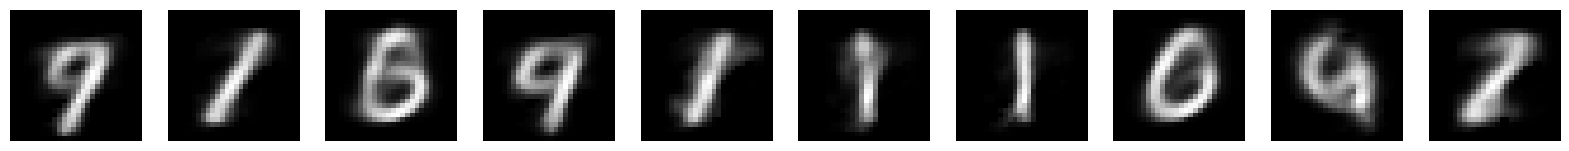

In [17]:
n_images = 10
z_gen = np.random.normal(size=(n_images, latent_dim))
x_gen = decoder.predict(z_gen)

fig, axes = plt.subplots(1, n_images, figsize=(20, 4))
for i in range(n_images):
    axes[i].imshow(x_gen[i].reshape(28, 28), cmap='gray')
    axes[i].axis('off')
plt.show()


Visualize the latent space

313/313 [==============================] - 1s 3ms/step


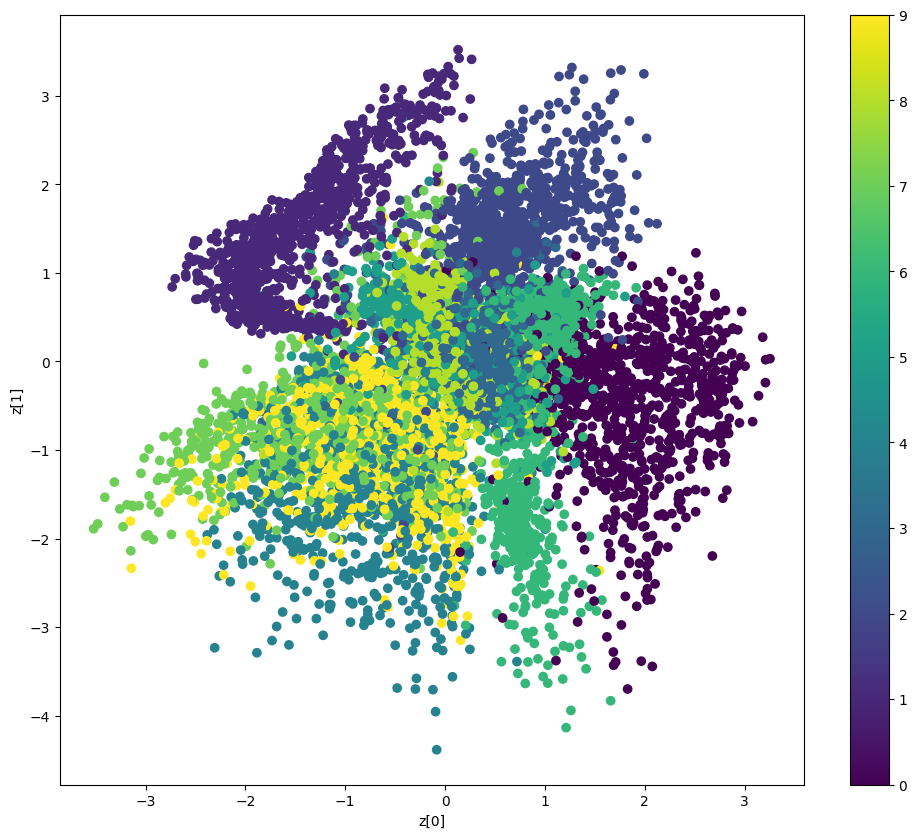

In [18]:
z_mean, _, _ = encoder.predict(X_test)
plt.figure(figsize=(12, 10))
plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test, cmap='viridis')
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()


Display a 2D manifold of the digits. It will show how digits transform from one to the other throughout the space.

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


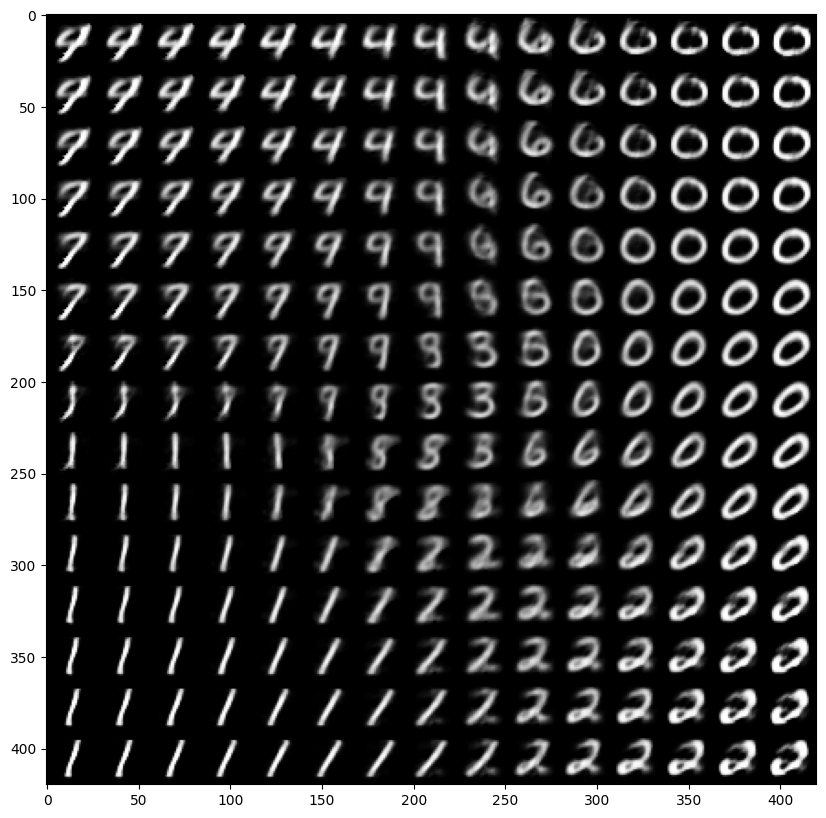

In [19]:
n = 15  # Grid size
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = np.linspace(-3, 3, n)
grid_y = np.linspace(-3, 3, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='gray')
plt.show()


## Bonus

TODO - Train with latent dim higher than 2 (but have in mind that we won't be able to visualize the manifold then). Try to change intermediate dimension. Try to make a simple convolutional VAE instead of fully connected.